In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

import geopandas as gpd

In [3]:
path = './data/disagg_struct_refs/sources/US/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')


In [4]:
# df_cnt = df.loc[df.agglvl_code == 76]
# df_msa = df.loc[df.agglvl_code == 46]
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_msa = pd.read_csv('./data/naics_area_msa_02_07.csv', index_col=[0, 1])
df_stt = pd.read_csv('./data/naics_area_stt_02_07.csv', index_col=[0, 1])

In [5]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
avg_wages = df_cnt[['total_annual_wages']].div(df_cnt[['annual_avg_emplvl']].values).dropna()

In [11]:
# Drop the unclassified!
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_cnt = df_cnt.loc[~(df_cnt.index.get_level_values('industry_code') == 9999)]

In [12]:
# Choose variable
variable = 'annual_avg_emplvl'
# variable = 'annual_avg_estabs'
df_cnt = df_cnt[[variable]]

### Population and land uses -> out

### Industries info

In [13]:
# X = df_stt.unstack()['annual_avg_estabs']
# X = df_msa.unstack()['annual_avg_estabs']
X = df_cnt.unstack()[variable]
X.columns = X.columns.astype(str)
X.index = X.index.astype(str).str.zfill(5)

X.shape



(3272, 317)

### Covariance Matrix

In [14]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

./../Hidalgo_Haussmann/HH_tools.py:58: RuntimeWarning: divide by zero encountered in log10
  return np.log10(df).replace(-np.inf, np.nan)


In [15]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

Tenemos cosine, corr del log, y sus versiones demeaned. Para hacer un pairplot.
## To which extent is it the same to take cos, demean it or take corr of logs? (the actual corr structure)

In [99]:

X.fillna(0)

### Cosine o Pearson
def cosine_similarity(table):
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
    return result

# X_ = demean(cor_mat)
X1 = cosine_similarity(X.fillna(0)).stack()
X2 = log10(X).fillna(0).corr(min_periods = 20).stack()
X3 = demean(cosine_similarity(X.fillna(0))).stack()
X4 = demean(log10(X).fillna(0).corr(min_periods = 40)).stack()
X5 = log10(RCA(X)).corr(min_periods = 40).stack()
X6 = demean(log10(RCA(X)).corr(min_periods = 40)).stack()
X7 = cosine_similarity(RCA(X).fillna(0)).stack()



In [105]:
data = pd.concat([X7, X1, X2, X3, X4, X5, X6], axis = 1)
data.columns = ['cosine_LQ', 'cos', 'corr_log', 'dem_cos', 'dem_corr_log', 'corr_log_LQ', 'dem_corr_log_LQ']

# data['dem_cos'] = (data - data.mean()).clip(-.3, .3)['dem_cos']
# data['dem_cos'] = data.clip(-.3, .4)['dem_cos']

In [103]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

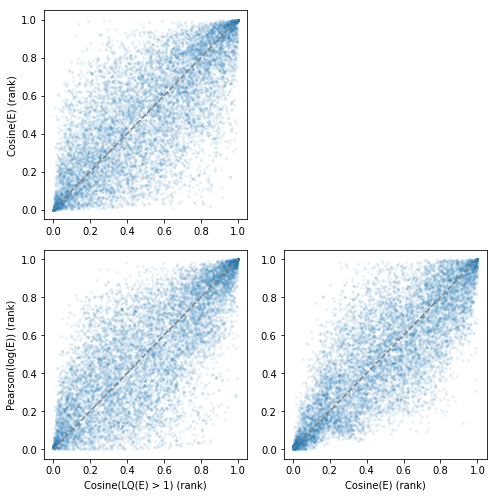

In [160]:
import seaborn as sns

# g = sns.pairplot(data.iloc[:, :3].rank(method = 'dense').fillna(0).sample(frac = .1), plot_kws={'alpha': .1, 'marker':'.', 'edgecolor': 'None'})
# for i, j in zip(*np.triu_indices_from(g.axes, 1)):
#     g.axes[i, j].set_visible(False)
# plt.show()

fig, axs = plt.subplots(2, 2, figsize = (7, 7))

data.rank(method = 'dense', pct = True).fillna(0).sample(frac = .1).plot('cosine_LQ', 'cos',alpha= .1,marker='.', mec= 'None', lw = 0, ax = axs[0, 0], legend = False)
data.rank(method = 'dense', pct = True).fillna(0).sample(frac = .1).plot('cosine_LQ', 'corr_log',alpha= .1,marker='.', mec= 'None', lw = 0, ax = axs[1, 0], legend = False)
data.rank(method = 'dense', pct = True).fillna(0).sample(frac = .1).plot('cos', 'corr_log',alpha= .1,marker='.', mec= 'None', lw = 0, ax = axs[1, 1], legend = False)
axs[0, 1].set_visible(False)

i, j = (0, 0)
# axs[i, j].set_xlabel('Cosine(LQ(E) > 1) (rank)')
axs[i, j].set_xlabel('')
axs[i, j].set_ylabel('Cosine(E) (rank)')
axs[i, j].plot([0, 1], [0, 1], c = '.5', linestyle = '--')

i, j = (1, 0)
axs[i, j].set_xlabel('Cosine(LQ(E) > 1) (rank)')
axs[i, j].set_ylabel('Pearson(log(E)) (rank)')
axs[i, j].plot([0, 1], [0, 1], c = '.5', linestyle = '--')

i, j = (1, 1)
axs[i, j].set_xlabel('Cosine(E) (rank)')
# axs[i, j].set_ylabel('Pearson(log(E)) (rank)')
axs[i, j].plot([0, 1], [0, 1], c = '.5', linestyle = '--')

plt.tight_layout()
plt.savefig('./../../Documents/geo-correlation-structures/Figures/figure_compare_similarities.png', )
plt.show()

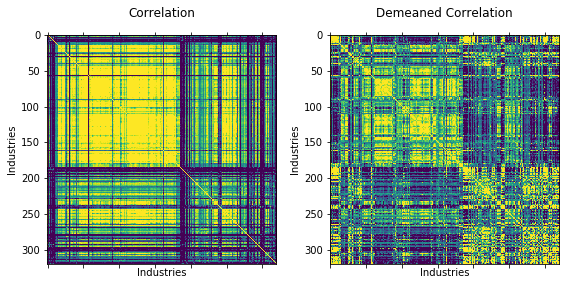

In [21]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 2, figsize = (8, 4))
# fig.suptitle('Correlation Matrix')

# axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)

axs[0].set_title('Correlation')
axs[0].set_xticklabels('')
axs[0].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7);axs[0].set_xlabel('Industries'); axs[0].set_ylabel('Industries')

axs[1].set_title('Demeaned Correlation')
axs[1].set_xticklabels('')
# axs[0].xaxis.set_tick_params(labelbottom='on')
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1); axs[1].set_xlabel('Industries'); axs[1].set_ylabel('Industries')


# plt.hist(stand(demean(cor_mat)).std(), 30)
plt.tight_layout()
# plt.savefig('./../../../../media/miglesia/Elements/WRITING/paper3_writing/figures/corr_matrix_demean_ill.png')
plt.show()

In [22]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering

### Cosine o Pearson

def cosine_similarity(table):
#     vals = table.values
    norms = np.linalg.norm(table, axis = 0)
    norm = np.outer(norms, norms)
    result = table.T.dot(table).div(norm)
#     return pd.DataFrame(result, columns = table.columns, index = table.index)
    return result

# X_ = demean(cor_mat)
X_ = demean(cosine_similarity(X.fillna(0)))

clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize", random_state=0).fit(X_.values)#,
#         random_state=0)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

clust_result.index.name = 'industry_code'

/home/miglesia/anaconda2/lib/python2.7/site-packages/sklearn/cluster/spectral.py:442: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


In [23]:
def color_from_series(df, ix_col, val_col, cmap = plt.cm.coolwarm):
    import matplotlib.colors as mcolors

    # create color reference
    qlo = df[val_col].quantile(.2)
    qhi = df[val_col].quantile(.8)
    norm = mcolors.Normalize(vmin=qlo, vmax=qhi, clip=True)
    mapper = plt.cm.ScalarMappable(norm = norm, cmap=cmap)
    df['color'] = df[val_col].apply(lambda x: mcolors.to_hex(mapper.to_rgba(x))) 
    color = df[[ix_col, 'color']]
    return color

### Wages

In [24]:
df_cnt = pd.read_csv('./data/naics_area_cnt_02_07.csv', index_col=[0, 1])
df_indu = df_cnt.groupby(level = 1).sum()
avg_wages_indu = df_indu[['total_annual_wages']].div(df_indu[['annual_avg_emplvl']].values).dropna()
avg_wages_indu = np.log10(avg_wages_indu)
avg_wages_indu = avg_wages_indu.reset_index()
avg_wages_indu['industry_code'] = avg_wages_indu['industry_code'].astype(str)

wages_color = color_from_series(avg_wages_indu, 'industry_code', 'total_annual_wages', 
                                cmap = plt.cm.RdYlGn).rename(columns = {'color': 'wage_color'})

### Sort clusters by size

In [25]:
df_indu = df_cnt.groupby(level = 1).sum()
df_indu.index = df_indu.index.astype(str)

cluster_data = pd.concat([clust_result, df_indu], axis = 1, sort = False)

cluster_data = cluster_data.groupby('cluster').agg({'industry_title': 'nunique', 'annual_avg_estabs': 'sum',
                                    'annual_avg_emplvl': 'sum', 'total_annual_wages': 'sum', })

cluster_data['avg_annual_wages'] = np.round(cluster_data.total_annual_wages / cluster_data.annual_avg_emplvl)

In [26]:
sorted_cluster_data = cluster_data.sort_values('annual_avg_estabs', ascending = False)

sorted_cluster_data.style.bar()

sorted_cluster_data = sorted_cluster_data.reset_index().reset_index()

clust_result = clust_result.reset_index().merge(sorted_cluster_data[['cluster', 'index']], how = 'left'
                                ).set_index('industry_code'
                                           ).drop('cluster', 1).rename(columns = {'index':'cluster'})

### Edges

In [27]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# edges = pd.DataFrame(demean(stand(demean(cor_mat))).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.9)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [28]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [29]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.gist_ncar)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))
nodes['color'] = nodes['color'].replace('#000080', '#9c28d2')

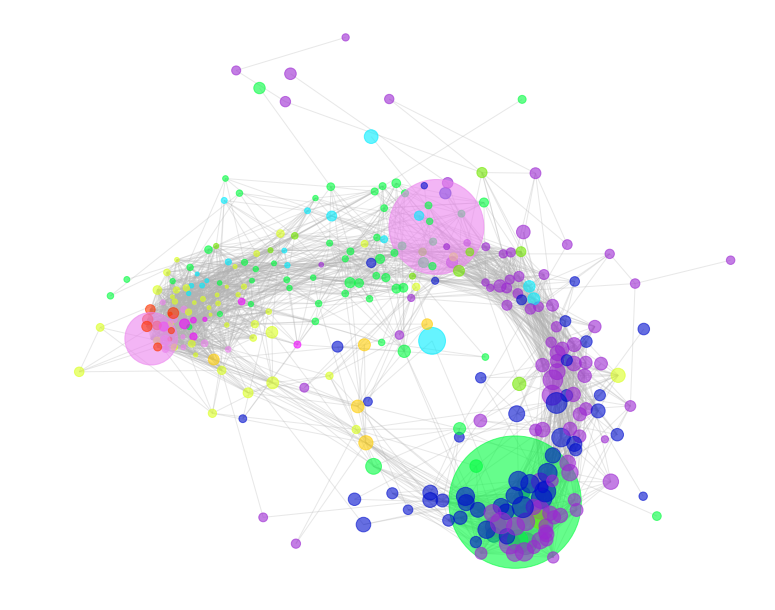

In [30]:
import json

max_d = 40
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_y').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]

## POSITIONS

# pos = nx.spring_layout(G, k=.3)

# def default(obj):
#     if type(obj).__module__ == np.__name__:
#         if isinstance(obj, np.ndarray):
#             return obj.tolist()
#         else:
#             return obj.item()
#     raise TypeError('Unknown type:', type(obj))

# # dumped = json.dumps(data, default=default)

# f = open("./data/node_layout","w")
# f.write(json.dumps(pos, default=default))

## POSITIONS. Compute VS Load file
# f = open('./data/node_layout', 'r')
# pos = json.loads(f.read())
pos = nx.spring_layout(G, k=.3)


nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

In [31]:
# xx

### Draw in d3plus

In [32]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [33]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 500 * nodes_[['x', 'y']]


In [34]:
nodes_s.head()

,sqrt_size,industry_title,cluster,color
1142,17.839563,NAICS 1142 Hunting and trapping,5,#dbff20
5173,85.906732,NAICS 5173 Wired and wireless telecommunicatio...,0,#9c28d2
5171,129.311832,NAICS12 5171 Wired telecommunications carriers,1,#000ecd
1141,45.170603,NAICS 1141 Fishing,9,#ec84ef
3335,104.200928,NAICS 3335 Metalworking machinery manufacturing,3,#00fd3f


In [35]:
# nodes_.sort_values(by = 'id')#.loc[nodes_.id == 'Desert']

In [36]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [37]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [38]:
## Conditional coloring

# Manufacturing (light_blue) and services (yellow)
nodes_['color_mfg_srv'] = 'D3D3D3' #Gray bckg

conditions = [
    (nodes_['industry_title'].str.lower().str.contains('manufacturing')) + (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('service')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (nodes_['industry_title'].str.lower().str.contains('wholesale')),# or (nodes_['industry_title'].str.lower().str.contains('mfg')),
    (-nodes_['industry_title'].str.lower().str.contains('naics'))]

choices = ['#000080', '#ffc400', '#00b0ff', '#FF0000']

nodes_['color_mfg_srv'] = np.select(conditions, choices, default='#D3D3D3')


/home/miglesia/anaconda2/lib/python2.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [39]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [40]:
nodes_ = nodes_.merge(wages_color, how = 'left', left_on = 'id', right_on = 'industry_code')

In [41]:
from IPython.display import HTML


In [42]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="wage_color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

name = 'wages'

visualization_html = ps.dump_html(nodes_)
# Dump it out in my_treemap.html
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
# display(HTML("""<a href="%s">Browse interactive network plot</a>""" % link))
open('./html/'+file_, "w+").write(visualization_html);

./modules/d3plus2.py:260: FutureWarning: Using 'rename_axis' to alter labels is deprecated. Use '.rename' instead
  return data.rename_axis({self.id: self.network_id}, axis=1)


<IPython.core.display.Javascript object>

In [43]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color_mfg_srv",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

name = 'anchors'

visualization_html = ps.dump_html(nodes_)
# Dump it out in my_treemap.html
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
# display(HTML("""<a href="%s">Browse interactive network plot</a>""" % link))
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

#### Which ones correlate most with...

In [44]:
target = 'total_annual_wages' # POPESTIMATE2010 	total_annual_wages 	ALAND

pop_nodes = X_[[target]].sort_values(target).tail(20)

pop_nodes = pd.concat([pop_nodes, nodes[['industry_title']], df_indu], axis = 1, sort = False).dropna()

pop_nodes.sort_values(by = 'annual_avg_emplvl')

,total_annual_wages,industry_title,annual_avg_estabs,annual_avg_emplvl,total_annual_wages
1132,0.325398,NAICS 1132 Forest nursery and gathering forest...,229.583333,1.388000e+02,2.423105e+06
1142,0.349400,NAICS 1142 Hunting and trapping,318.250000,1.798000e+02,4.007286e+06
1131,0.400681,NAICS 1131 Timber tract operations,552.083333,4.720600e+03,2.347921e+08
1153,0.390757,NAICS 1153 Support activities for forestry,1988.966667,8.222033e+03,2.344038e+08
1122,0.421513,NAICS 1122 Hog and pig farming,1666.650000,9.141267e+03,2.404101e+08
1123,0.329156,NAICS 1123 Poultry and egg production,1395.050000,1.462100e+04,3.996607e+08
1111,0.384994,NAICS 1111 Oilseed and grain farming,5828.816667,1.747165e+04,4.371915e+08
2121,0.368947,NAICS 2121 Coal mining,1043.366667,2.543600e+04,1.462854e+09
1133,0.524924,NAICS 1133 Logging,9200.466667,3.560952e+04,1.119585e+09
2123,0.375034,NAICS 2123 Nonmetallic mineral mining and quar...,4719.733333,3.860195e+04,1.768340e+09


In [45]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

name = 'clusters'

visualization_html = ps.dump_html(nodes_)
# Dump it out in my_treemap.html
file_ = name + '_nwplot.html'
link = "http://matiasdice.com/other/"+file_
# display(HTML("""<a href="%s">Browse interactive network plot</a>""" % link))
open('./html/'+file_, "w+").write(visualization_html);

<IPython.core.display.Javascript object>

In [46]:
nodes.groupby('cluster').color.unique()

cluster
0    [#9c28d2]
1    [#000ecd]
2    [#00edff]
3    [#00fd3f]
4    [#74e800]
5    [#dbff20]
6    [#ffce05]
7    [#ff3400]
8    [#f107ff]
9    [#ec84ef]
Name: color, dtype: object

### Activities by cluster

In [57]:

nodes.to_csv('./../data/naics_cluster_color.csv')

In [48]:
# Save total establishments by spectral analysis cluster, and county:
# xx
X_area_cluster = pd.concat([nodes[['cluster']], X.T], axis = 1)
X_area_cluster = X_area_cluster.iloc[10:]
X_area_cluster = X_area_cluster.groupby('cluster').sum().T
X_area_cluster.to_csv('./data/X_county_cluster.csv')

X_area_cluster.head()

cluster,0,1,2,3,4,5,6,7,8,9
01001,287.716667,314.150000,21.300000,55.533333,17.333333,24.400000,18.6,0.000000,1.200000,0.6
01003,1932.000000,1870.866667,138.800000,218.033333,89.383333,109.866667,40.0,9.066667,4.200000,8.7
01005,177.450000,208.300000,21.066667,40.650000,14.600000,28.000000,25.4,0.000000,1.600000,10.4
01007,71.483333,126.883333,2.400000,30.666667,3.600000,18.033333,15.0,1.000000,0.333333,6.2
01009,180.950000,354.483333,10.033333,84.116667,5.800000,21.750000,24.8,1.000000,0.600000,1.8


In [49]:
# X_area_cluster.loc['46113']

In [50]:
# X.T.iloc[10:].sum().sum()/1e6

In [51]:
clusters = nodes.loc[nodes.industry_title.str.contains('NAICS')].reset_index().rename(columns = {'index': 'industry_code'})[['industry_code', 'industry_title', 'cluster', 'color']]
clusters.to_csv('./data/clusters.csv', index = False)

In [52]:
pd.set_option('display.max_colwidth', -1)
summary = nodes.loc[nodes.industry_title.str.contains('NAICS')].groupby('cluster').apply(lambda x: x.sample(3))#.agg({'industry_title': 'first', 'color':[ 'first', 'count']})
# summary.columns = ['color', 'node_count','example']
summary.sort_index()#.sort_values(by = 'node_count')

sqrt_size  \
cluster                    
0       4431  232.112150   
        5322  174.157017   
        5412  345.375834   
1       4542  70.877241    
        4812  50.831749    
        7131  46.720445    
2       3161  15.442906    
        3351  35.441266    
        6222  36.169969    
3       3112  26.984563    
        3113  42.414620    
        3353  50.257835    
4       3169  26.623924    
        4243  120.319020   
        7111  98.272665    
5       3117  28.724554    
        4879  13.714955    
        5211  15.387766    
6       9211  202.831252   
        9221  162.472664   
        9241  119.388442   
7       1121  110.553682   
        1124  16.112624    
        1151  94.534738    
8       2111  83.667198    
        2131  99.456942    
        3331  53.803965    
9       1153  44.597833    
        2121  32.301187    
        2122  16.407823    

                                                        industry_title  \
cluster                                                                  
0       4431  NAICS 4431 Electronics and appliance stores                
        5322  NAICS 5322 Consumer goods rental                           
        5412  NAICS 5412 Accounting and bookkeeping services             
1       4542  NAICS 4542 Vending machine operators                       
        4812  NAICS 4812 Nonscheduled air transportation                 
        7131  NAICS 7131 Amusement parks and arcades                     
2       3161  NAICS 3161 Leather and hide tanning and finishing          
        3351  NAICS 3351 Electric lighting equipment manufacturing       
        6222  NAICS 6222 Psychiatric and substance abuse hospitals       
3       3112  NAICS 3112 Grain and oilseed milling                       
        3113  NAICS 3113 Sugar and confectionery product manufacturing   
        3353  NAICS 3353 Electrical equipment manufacturing              
4       3169  NAICS 3169 Other leather product manufacturing             
        4243  NAICS 4243 Apparel and piece goods merchant wholesalers    
        7111  NAICS 7111 Performing arts companies                       
5       3117  NAICS 3117 Seafood product preparation and packaging       
        4879  NAICS 4879 Scenic and sightseeing transportation, other    
        5211  NAICS 5211 Monetary authorities - central bank             
6       9211  NAICS 9211 Executive, legislative and general government   
        9221  NAICS 9221 Justice, public order, and safety activities    
        9241  NAICS 9241 Administration of environmental programs        
7       1121  NAICS 1121 Cattle ranching and farming                     
        1124  NAICS 1124 Sheep and goat farming                          
        1151  NAICS 1151 Support activities for crop production          
8       2111  NAICS 2111 Oil and gas extraction                          
        2131  NAICS 2131 Support activities for mining                   
        3331  NAICS 3331 Ag., construction, and mining machinery mfg.    
9       1153  NAICS 1153 Support activities for forestry                 
        2121  NAICS 2121 Coal mining                                     
        2122  NAICS 2122 Metal ore mining                                

              cluster    color  
cluster                         
0       4431  0        #9c28d2  
        5322  0        #9c28d2  
        5412  0        #9c28d2  
1       4542  1        #000ecd  
        4812  1        #000ecd  
        7131  1        #000ecd  
2       3161  2        #00edff  
        3351  2        #00edff  
        6222  2        #00edff  
3       3112  3        #00fd3f  
        3113  3        #00fd3f  
        3353  3        #00fd3f  
4       3169  4        #74e800  
        4243  4        #74e800  
        7111  4        #74e800  
5       3117  5        #dbff20  
        4879  5        #dbff20  
        5211  5        #dbff20  
6       9211  6        #ffce05  
        9221  6        #ffce05  
        9241  6        

In [53]:
nodes_['color'].value_counts().index

Index([u'#9c28d2', u'#00fd3f', u'#000ecd', u'#dbff20', u'#00edff', u'#74e800',
       u'#ec84ef', u'#ff3400', u'#f107ff', u'#ffce05'],
      dtype='object')

In [54]:
# land-use clusters
nodes_.loc[nodes_['color'].isin(['#f10800', '#ff6800', '#ceff29', '#29ffce'])].sort_values(by = ['color','industry_title'])

#population cluster
nodes_.loc[nodes_['color'].isin(['#7dff7a'])].sort_values(by = ['color','industry_title'])

#'yellow' services cluster
nodes_.loc[nodes_['color'].isin(['#ffc400'])].sort_values(by = ['color','industry_title'])

#state/public sector cluster
# nodes_.loc[nodes_['color'].isin(['#004cff'])].sort_values(by = ['color','industry_title'])

#others/mfg clusters
# nodes_.loc[nodes_['color'].isin(['#000080', '#0000f1', '#00b0ff'])].sort_values(by = ['industry_title'])

# coastal?
# nodes_.loc[nodes_['color'].isin(['#0000f1'])].sort_values(by = ['color','industry_title'])

,id,x,y,industry_title,color,presence,color_mfg_srv,industry_code,wage_color


### Keywords by cluster

In [55]:
# Cluster 7, #ffc400 are 76 nodes that follow neither population nor land resources. Then what is it all about?
from collections import Counter
from nltk.corpus import stopwords 
stop_words = set(stopwords.words('english')) 

from IPython.display import display, HTML
import colorlover as cl    
    
for clsr in range(10):
    try:
        
        text = nodes.loc[nodes.cluster == clsr]['industry_title']

        r1 = text.str.lower().str.split().values
        r1 = [item for sublist in r1 for item in sublist]

        r1_f = [w.replace(',', '').replace('mfg.', 'manufacturing') for w in r1 if not w in stop_words] 

#         print(summary.loc[clsr])
        color = summary.loc[clsr]['color']
#         display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))
        print(Counter(r1_f).most_common()[:10])
        print('\n')
    except:
        pass

[('naics', 86), ('services', 25), ('stores', 13), ('related', 7), ('merchant', 6), ('goods', 6), ('wholesalers', 6), ('activities', 4), ('offices', 4), ('manufacturing', 4)]


[('naics', 58), ('merchant', 7), ('wholesalers', 7), ('services', 7), ('care', 6), ('building', 6), ('construction', 5), ('stores', 4), ('naics12', 4), ('contractors', 4)]


[('naics', 17), ('manufacturing', 6), ('mills', 3), ('video', 2), ('equipment', 2), ('product', 2), ('apparel', 2), ('sew', 1), ('colleges', 1), ('nondurable', 1)]


[('naics', 63), ('manufacturing', 39), ('product', 15), ('equipment', 7), ('mills', 4), ('machinery', 4), ('furniture', 3), ('steel', 3), ('facilities', 2), ('paper', 2)]


[('naics', 11), ('wholesalers', 2), ('merchant', 2), ('manufacturing', 2), ('goods', 2), ('apparel', 2), ('real', 1), ('managers', 1), ('3133', 1), ('estate', 1)]


[('naics', 43), ('transportation', 11), ('manufacturing', 8), ('water', 4), ('support', 4), ('scenic', 3), ('sightseeing', 3), ('production', 3), 

In [56]:
display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))


AttributeError: 'Series' object has no attribute 'lstrip'

### Map distribution from different clusters

In [ ]:
# nodes
import geopandas as gpd

counties = gpd.read_file('./data/cb_2017_us_county_500k/cb_2017_us_county_500k.shp')
counties['area_fips'] = counties.STATEFP + counties.COUNTYFP


In [ ]:
### A little trick. Distribution of neigbors of node 'Naics 5417 Scientific Research and Development Services'
# nodes_.loc[nodes_.id == '5417']
ego_node = 'Desert' #'Cropland' #'POPESTIMATE2010'# '5417'

neigh = edges_max_d_triangles.loc[(edges_max_d_triangles.industry_code_x == ego_node) |
                                  (edges_max_d_triangles.industry_code_y == ego_node)]
neigh_ids = list(set(neigh['industry_code_x'].unique()).union(set(neigh['industry_code_y'].unique())))
# nodes_.loc[nodes_.id.isin(neigh_ids)]['id'].values

node_ids = neigh_ids

In [ ]:
# gdf.loc[gdf.industry_code == naics]['annual_avg_estabs']
# df_neigh
# df_neigh.groupby('industry_code').mean().sort_values(by = 'annual_avg_estabs').tail(5).index

In [ ]:
from PIL import Image, ImageDraw, ImageFont


In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)[variable].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')[variable].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

i = 0
open('./Figures/7_compo_USA_nw/labels.txt', 'w').close()
for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())

    # Sample of cluster color
    rgb_tuple = tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))
    im = Image.new('RGBA', (20, 20), rgb_tuple)
    im.save('./Figures/7_compo_USA_nw/cp_'+str(i)+'.png')

    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .2 ):#& (i <=5): # Dismiss small indus
            node_info = nodes_.loc[nodes_.id == naics]
            
            # send node labels to test (they will then go to svg of figure)
            with open('./Figures/7_compo_USA_nw/labels.txt', 'a') as f:
                f.write(node_info['industry_title'].values[0]+'\n')
            display(node_info)
            display(HTML(cl.to_html( [rgb_tuple] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
#             plt.axis('off')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
            plt.text(-128, 23.5, 'NAICS '+str(node_info['id'].values[0]), fontsize=30) # position in lat lon
            plt.savefig('./Figures/7_compo_USA_nw/'+str(node_info['id'].values[0])+'.png', bbox_inches = 'tight')
            plt.show()
    i+=1

In [ ]:
# TXT2InkscapeXMLv3.py

# A simple Python 3 script to look through a list of text and
# turn each line into an xml entry for use in Inkscape.
# in this script we will slightly spread the text to allow
# the user a better chance of retaining the order of their
# initial text.  Inkscape can be used to spread it out
# using the Align and Distribute Tool.


ofilenm = './Figures/7_compo_USA_nw/figure.svg'#str(input("What is the filename you wish for output?"))
outfile = open(ofilenm,"w")

ListFlm = './Figures/7_compo_USA_nw/labels.txt'#str(input("What is the name and location of the TXT file to work with?"))

Loctn = 75 #Vertical position to start text insertion
SpacingV = 25  #The vertical spacing between lines.

# The block that follows is the Inkscape standard header.
TextBlockA = '''<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   xmlns:dc="http://purl.org/dc/elements/1.1/"
   xmlns:cc="http://creativecommons.org/ns#"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:svg="http://www.w3.org/2000/svg"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   width="744.09448819"
   height="1052.3622047"
   id="svg2"
   version="1.1"
   inkscape:version="0.48.4 r9939"
   sodipodi:docname="New document 1">
  <defs
     id="defs4" />
  <sodipodi:namedview
     id="base"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:pageopacity="0.0"
     inkscape:pageshadow="2"
     inkscape:zoom="0.35"
     inkscape:cx="375"
     inkscape:cy="520"
     inkscape:document-units="px"
     inkscape:current-layer="layer1"
     showgrid="false"
     inkscape:window-width="1280"
     inkscape:window-height="742"
     inkscape:window-x="-2"
     inkscape:window-y="-3"
     inkscape:window-maximized="1" />
  <metadata
     id="metadata7">
    <rdf:RDF>
      <cc:Work
         rdf:about="">
        <dc:format>image/svg+xml</dc:format>
        <dc:type
           rdf:resource="http://purl.org/dc/dcmitype/StillImage" />
        <dc:title></dc:title>
      </cc:Work>
    </rdf:RDF>
  </metadata>
  <g
     inkscape:label="Layer 1"
     inkscape:groupmode="layer"
     id="layer1">'''

TextBlockB = '''<text\n
        xml:space="preserve"
        style="font-size:20px;font-style:normal;font-weight:normal;line-height:125%;letter-spacing:0px;word-spacing:0px;fill:#000000;fill-opacity:1;stroke:none;font-family:Sans"
        x="93.910118"
        y="'''
TextBlockC = '''id="text2989"
        sodipodi:linespacing="150%"><tspan
            sodipodi:role="line"
            id="tspan2991"
            x="93.910118"
            y="'''

outfile.write(TextBlockA)

# The section that follows is to build the SVG text elements
f = open(ListFlm,"r")
for line in f:
    TXTLine = line.strip()
    Loctn = Loctn + SpacingV
    InsertStrng1 = str(Loctn)+'"\n'
    InsertStrng2= str(Loctn)+'">'+TXTLine+'</tspan></text>\n'
    outfile.write(TextBlockB)
    outfile.write(InsertStrng1)
    outfile.write(TextBlockC)
    outfile.write(InsertStrng2)

# The next section is the close off for the SVG xml.

outfile.write('  </g>\n')
outfile.write('</svg>\n')

outfile.close()
print("Done")

In [ ]:
# Choose indus to process...
n = 5
merged = df_agglv_yravg.groupby(level = 1)['annual_avg_estabs'].sum().reset_index().merge(nodes_, left_on = 'industry_code', right_on = 'id')
display_indus = merged.loc[merged.groupby('color')['annual_avg_estabs'].nlargest(n).index.get_level_values(1)]

#Filter original data to have these neighboring industries
df_agglv = df.loc[df.agglvl_code == 76]

df_agglv_yravg = df_agglv.groupby(['area_fips', 'industry_code']).mean().drop(['agglvl_code','year'], axis = 1)
# df_indu_prc_area = df_agglv_yravg.groupby(level=0).apply(lambda x: 100 * x / x.sum())
df_indu_prc_area = log10(df_agglv_yravg)

df_ = df_indu_prc_area.reset_index()

for color in nodes_.color.unique():
  
    cluster_ids = nodes_.loc[nodes_.color == color]['id']
    node_ids = cluster_ids.values
    
    df_neigh = df_.loc[df_.industry_code.isin(nodes_.loc[nodes_.id.isin(node_ids)]['id'].values)]
    df_neigh = df_neigh.set_index('area_fips')
    
    counties_ = counties.set_index('area_fips').reindex(df_neigh.index)[['geometry']]
    gdf = gpd.GeoDataFrame(pd.concat([df_neigh, counties_], axis = 1, sort = True).dropna())
    
    for naics in display_indus['industry_code'].values:
        if( gdf.loc[gdf.industry_code == naics]['annual_avg_estabs'].mean() > .45 ):#& (i <=5): # Dismiss small indus
            display(nodes_.loc[nodes_.id == naics])
            display(HTML(cl.to_html( [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2 ,4))] )))

            ax = gdf.loc[gdf.industry_code == naics].plot(
                column='annual_avg_estabs', cmap=plt.cm.gist_yarg, vmin = 0, vmax = 1.5, linewidth = 0, figsize = (10, 6.5))
            ax.set_xlim(-130, -60)
            ax.set_ylim(22, 50)#, figsize=figsize, scheme='equal_interval', k=colors, legend=True)
            plt.show()
            i+=1

### Color by Population Density

In [ ]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

In [ ]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [ ]:
nodes_

In [ ]:
# pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
# pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'id'})
# nodes_ = nodes_.merge(pop_dens_index, on = 'id', how = 'left') # industry_title / node_name
# # nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

# from numpy import nan
# rainbow_colors = {0:'#9400D3', #Violet
# 1:'#4B0082', #Indigo
# 2:'#0000FF', #Blue
# 3:'#00FF00', #Green
# nan:'#D3D3D3',  #'#D3D3D3', #Gray
# 4:'#FFFF00', #Yellow
# 5:'#FF7F00', #Orange
# 6:'#FF0000'} #Red

# nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

# network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [ ]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

In [ ]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()